# Clustering diabetic patients in 130 US hospitals

## Probelm Statement

It is increasingly recognized that the management of diabetes in the hospitalized patient has a significant bearing on outcome, in terms of both morbidity and mortality. However, considering the severity of the situation, there are few researches and assessment projects to aid diabetes care during hospitalizations. One crucial contribution is to categorize patients by considering their demographic, care,diagnosis & treatment as well as their prior hospital visit information.

This project aimes to cluster diabetic patient information from a dataset representing 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital information. Source: http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [1]:
# import the required packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# !pip install umap-learn
from umap import UMAP

import scipy.cluster.hierarchy as sch
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

#!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids
# !pip3 install gower
import gower
import prince

C:\DS\anaconda3\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [158]:
import scipy
def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [75]:
# read data
diabetic=pd.read_csv('c:\data\diabetic.csv',na_values='?')
diabetic.head()

C:\DS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Pre-processing

In [3]:
# Get summry information about the dataset
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [76]:
diabetic.shape

(101766, 50)

In [77]:
# Check the presence of missing values
diabetic.isna().mean().sort_values(ascending=False)

weight                      0.968585
medical_specialty           0.490822
payer_code                  0.395574
race                        0.022336
diag_3                      0.013983
diag_2                      0.003518
diag_1                      0.000206
num_procedures              0.000000
max_glu_serum               0.000000
number_diagnoses            0.000000
number_inpatient            0.000000
number_emergency            0.000000
number_outpatient           0.000000
num_medications             0.000000
readmitted                  0.000000
num_lab_procedures          0.000000
diabetesMed                 0.000000
time_in_hospital            0.000000
admission_source_id         0.000000
discharge_disposition_id    0.000000
admission_type_id           0.000000
age                         0.000000
gender                      0.000000
patient_nbr                 0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
n

In [78]:
diabetic=diabetic.drop(columns=['weight']) #97% of its value is missing

In [79]:
# Drop id columns and codes
# dropped medical_speciality column due high missing value and less relevant to the study
# following discussion with an expert in the field
drop=['encounter_id','patient_nbr','admission_type_id','discharge_disposition_id','admission_source_id', 'payer_code','medical_specialty']
diabetic=diabetic.drop(columns=drop)

In [80]:
# Drop other missing values due to availability of sufficient dataset
# Overall percentage dropped is <3%
diabetic=diabetic.dropna()

In [81]:
diabetic.shape

(98053, 42)

In [82]:
diabetic.isna().mean().sort_values(ascending=False)

readmitted                  0.0
diag_1                      0.0
nateglinide                 0.0
repaglinide                 0.0
metformin                   0.0
A1Cresult                   0.0
max_glu_serum               0.0
number_diagnoses            0.0
diag_3                      0.0
diag_2                      0.0
number_inpatient            0.0
diabetesMed                 0.0
number_emergency            0.0
number_outpatient           0.0
num_medications             0.0
num_procedures              0.0
num_lab_procedures          0.0
time_in_hospital            0.0
age                         0.0
gender                      0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
change                      0.0
metformin-pioglitazone      0.0
metformin-rosiglitazone     0.0
glimepiride-pioglitazone    0.0
glipizide-metformin         0.0
glyburide-metformin         0.0
insulin                     0.0
citoglip

In [83]:
# drop invalide rows for gender variable
diabetic = diabetic[diabetic['gender'] !='Unknown/Invalid'] 

In [84]:
# Drop columns with same values for every records
same_value_cols=['glimepiride','glipizide-metformin','metformin-pioglitazone','metformin-rosiglitazone','citoglipton',
                    'examide', 'glimepiride-pioglitazone','acetohexamide']
diabetic=diabetic.drop(columns=same_value_cols)

In [85]:
# Drop columns with rare medications(<0.0001%)
rare_med=['nateglinide','rosiglitazone','acarbose','troglitazone','glyburide-metformin','tolazamide',
            'chlorpropamide','insulin','troglitazone']

for col in rare_med:
    med_count=diabetic[col].value_counts()
    diabetic= diabetic[diabetic[col].isin(med_count[med_count > 10].index)]

In [86]:
# Drop groups with fewer/rare values 
# Domain expert consulted
count_d1 = diabetic["diag_1"].value_counts()
diabetic= diabetic[diabetic['diag_1'].isin(count_d1[count_d1 > 10].index)]

count_d2=diabetic['diag_2'].value_counts()
diabetic= diabetic[diabetic['diag_2'].isin(count_d2[count_d2 > 10].index)]

count_d3=diabetic['diag_3'].value_counts()
diabetic= diabetic[diabetic['diag_3'].isin(count_d3[count_d3 > 10].index)]

In [87]:
# Define which columns are categorical -> to be ecoded
# which columns are numerical -> to be scaled
cat_cols = diabetic.select_dtypes('O').columns
num_cols  = diabetic.select_dtypes('number').columns

In [88]:
for col in cat_cols:
    print(f"\n------- {col} -------------")
    print(diabetic[col].value_counts())


------- race -------------
Caucasian          72015
AfricanAmerican    18127
Hispanic            1866
Other               1410
Asian                592
Name: race, dtype: int64

------- gender -------------
Female    50594
Male      43416
Name: gender, dtype: int64

------- age -------------
[70-80)     24494
[60-70)     21029
[80-90)     16193
[50-60)     15947
[40-50)      8749
[30-40)      3255
[90-100)     2647
[20-30)      1272
[10-20)       379
[0-10)         45
Name: age, dtype: int64

------- diag_1 -------------
428    6679
414    6327
786    3846
410    3485
486    3363
       ... 
462       9
977       8
660       8
158       8
945       6
Name: diag_1, Length: 376, dtype: int64

------- diag_2 -------------
428    6423
276    6307
250    5242
427    4837
401    3556
       ... 
959      10
241      10
824      10
382       9
607       8
Name: diag_2, Length: 354, dtype: int64

------- diag_3 -------------
250    10814
401     7876
276     5004
428     4423
427     3823
   

In [89]:
demographic_cols=['age','race','gender']

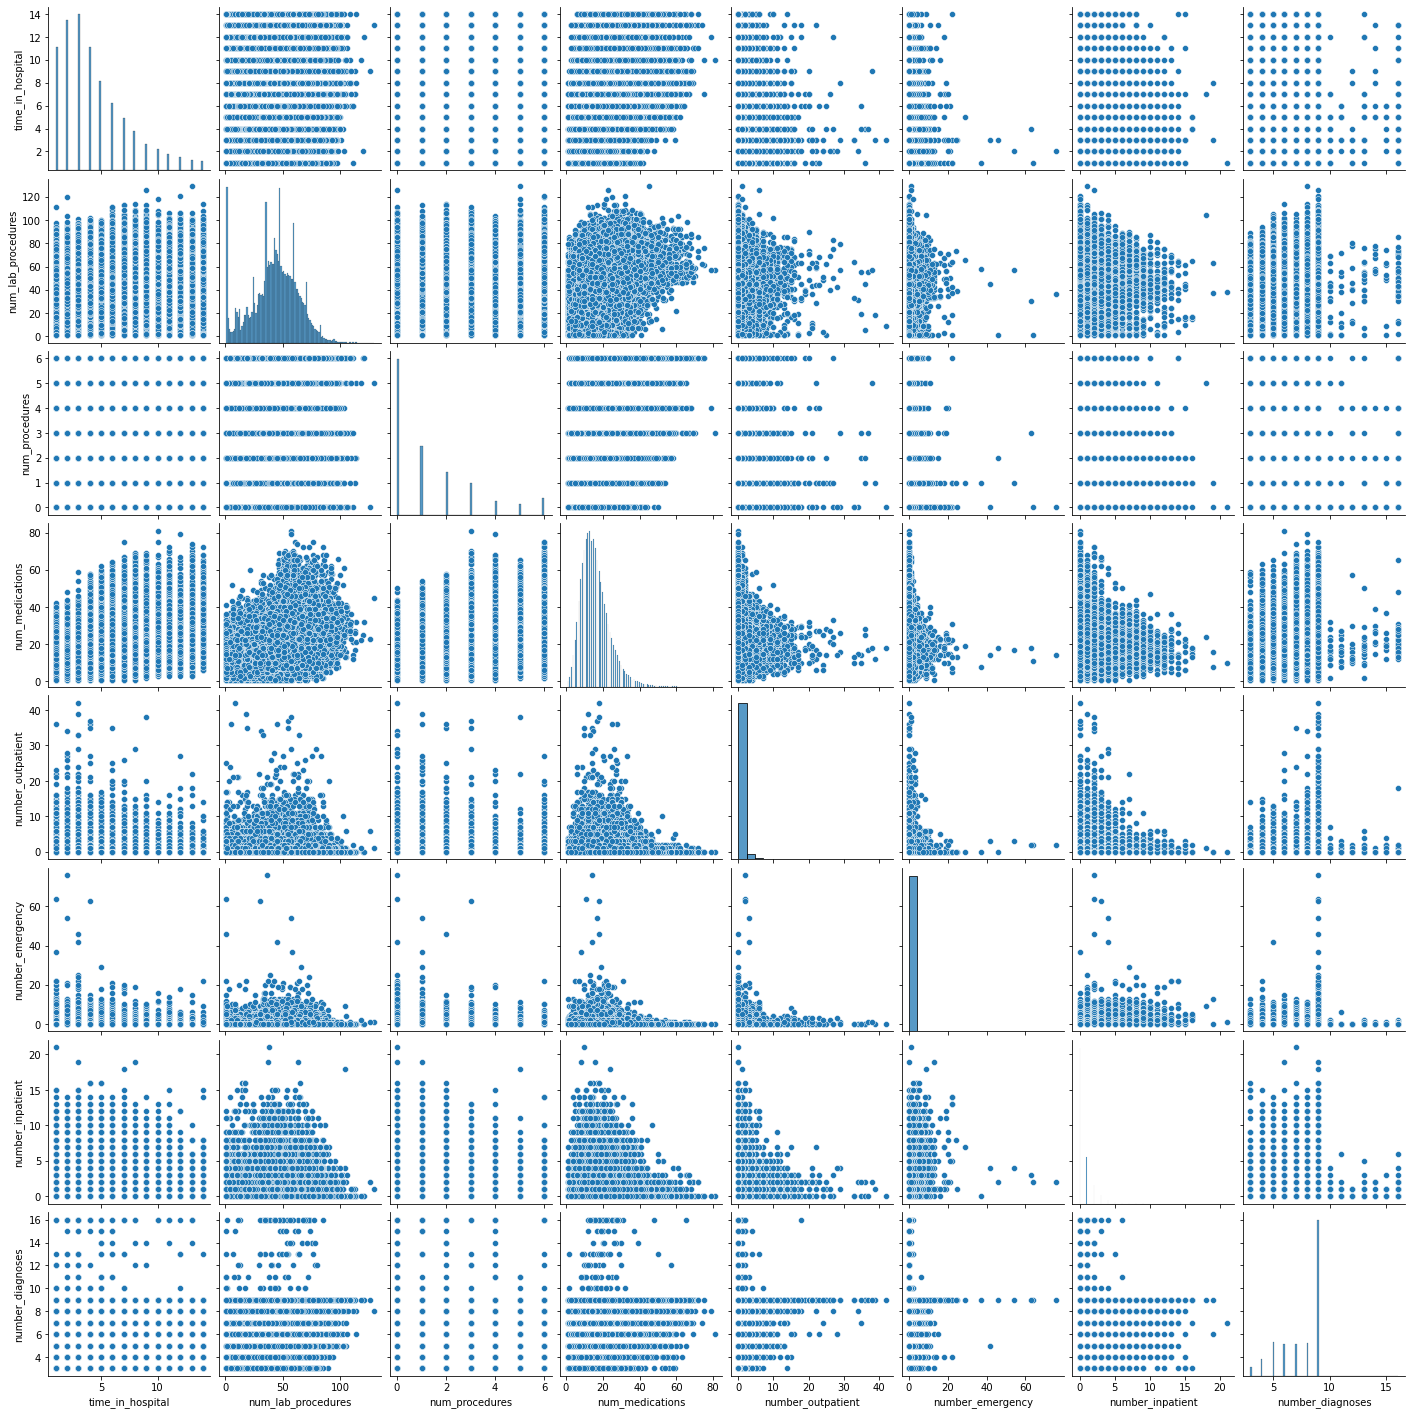

In [19]:
sns.pairplot(diabetic[num_cols])
plt.show()

In [90]:
# explore unique values for demographic variables
for col in demographic_cols:
    print(diabetic[col].value_counts())

[70-80)     24494
[60-70)     21029
[80-90)     16193
[50-60)     15947
[40-50)      8749
[30-40)      3255
[90-100)     2647
[20-30)      1272
[10-20)       379
[0-10)         45
Name: age, dtype: int64
Caucasian          72015
AfricanAmerican    18127
Hispanic            1866
Other               1410
Asian                592
Name: race, dtype: int64
Female    50594
Male      43416
Name: gender, dtype: int64


C:\DS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


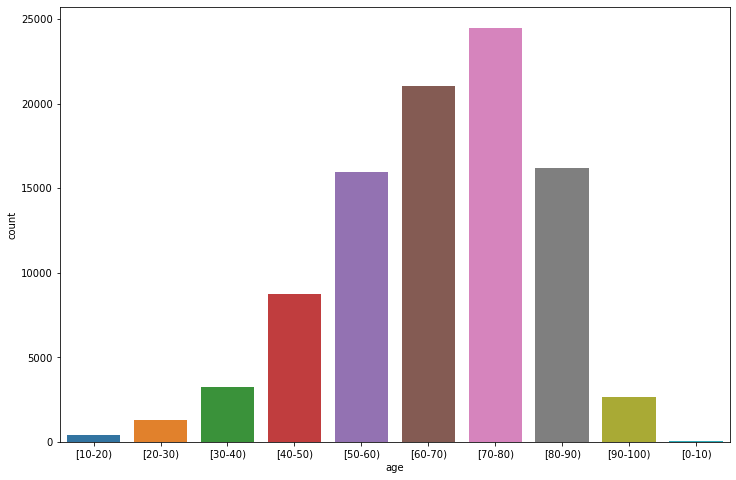

C:\DS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


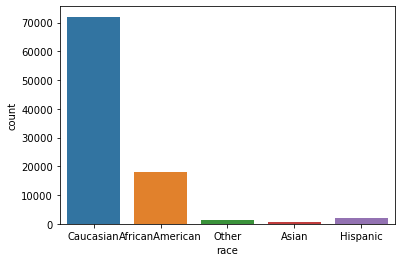

C:\DS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


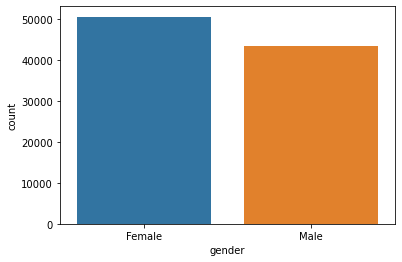

In [91]:
plt.figure(figsize=(12,8))
for col in demographic_cols:
    sns.countplot(diabetic[col])
    plt.show()

In [92]:
# Update the category columns to reflect the changes above
cat_cols = diabetic.select_dtypes('O').columns

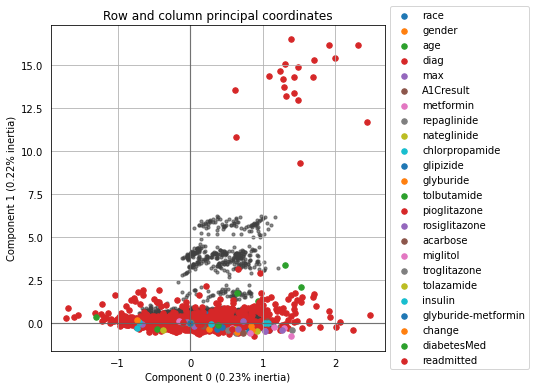

In [93]:
# Visualize underlying structure of the categorical dataset
mca = prince.MCA()
mca.fit(diabetic[cat_cols])

mca.plot_coordinates(diabetic[cat_cols])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [96]:
# Due to size of dataset and high dimensionality, memory will easily fillup. 
# So, random sample data, n=10000, has been taken.
diabetic=diabetic.sample(n = 5000, random_state=143) 

Create a copy of the dataframe to preserve this original structure for cluster analysis later.

In [97]:
# Save the original copy of the dataset 
diab_orig=diabetic.copy()

As the dataset contains categorical and numeric data, encoding and scaling is performed separately and resulsts are combined.

In [98]:
# Instantiate encoder/scaler
scaler = StandardScaler()

# Scale and Encode Separate Columns
scaled = scaler.fit_transform(diabetic[num_cols])
scaled=pd.DataFrame(scaled,columns=num_cols, index=diabetic.index)

encoded = pd.get_dummies(diabetic[cat_cols])

In [99]:
# Combine scaled and encoded variables into a single dataframe
diabetic = pd.concat([scaled, encoded],axis=1)
diabetic

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
34959,-0.112535,0.462922,0.944674,-0.872825,-0.321876,-0.257304,-0.516807,0.812072,0,0,...,0,1,0,0,1,1,0,0,0,1
88832,0.223591,-0.096974,0.364051,0.492244,-0.321876,1.048808,1.799327,0.265369,0,0,...,1,1,0,1,0,0,1,0,1,0
100756,-1.120911,0.004825,0.944674,-1.245116,0.575714,-0.257304,-0.516807,0.812072,1,0,...,0,1,0,0,1,1,0,0,0,1
68261,-0.448660,0.157524,-0.216573,0.740438,-0.321876,-0.257304,-0.516807,0.812072,0,0,...,1,1,0,1,0,0,1,0,0,1
81643,0.223591,0.157524,0.364051,1.236826,-0.321876,-0.257304,1.027283,0.812072,0,0,...,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21293,2.912593,0.971918,0.364051,0.368146,-0.321876,-0.257304,0.255238,0.812072,0,0,...,0,1,0,0,1,1,0,0,0,1
76733,-0.112535,0.157524,-0.797196,0.244049,-0.321876,-0.257304,-0.516807,0.812072,1,0,...,0,1,0,1,0,0,1,0,1,0
101562,0.223591,1.226416,-0.797196,-0.872825,-0.321876,1.048808,0.255238,0.812072,0,0,...,0,1,0,0,1,1,0,0,1,0
92418,-0.784785,-0.198773,-0.797196,-0.996922,-0.321876,-0.257304,-0.516807,0.812072,0,0,...,0,1,0,0,1,1,0,1,0,0


Gower distance is choosen because the dataset is a mixed dataset that consists of numerical and categorical variables; and gower distance is the most approprate metric.

In [100]:
# Calculate gower distance
dist=gower.gower_matrix(diabetic)

To visualize data in two dimensional UMAP is used.  UMAP supports a wide variety of distance metrics; precomputed is used as a distance metric and distance matrix is used as an input.

In [34]:
umap = UMAP(n_neighbors=5, n_components=2,metric='precomputed')
diab_umap = umap.fit_transform(dist)

C:\DS\anaconda3\lib\site-packages\umap\umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


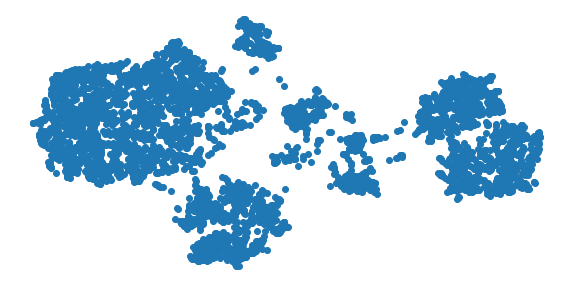

In [36]:
# visualize the dataset in two-dimensional space using the first two components of the UMAP
df_diab_umap = pd.DataFrame(diab_umap, index=diabetic.index, columns=['umap1', 'umap2'])
plt.figure(figsize=(10,5))
plt.scatter(diab_umap[:, 0], diab_umap[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
We can clearly identify 4/5 regions in the data, which can be used as a starting point to the number of clusters to be used.

# Clustering

## Hierarchical Clustering

Though hierarchical clustering doesn't assume apriori knowledge about the number of clusters, we can make an 'educated guess' on the no of clusters by using the previous knowledge from UMAP 'plot' and by using silhouette score plot (highest score mostly related to optimal no clusters.

In [129]:
# We can also plot dendogram to have a generic information about the clustering structure
# However, for large dataset, things get complex
plt.figure(figsize=(30,20))
dendrogram(linkage(dist, method='complete'))
plt.show()

<ipython-input-129-2bc19c00cf12>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(dist, method='complete'))


KeyboardInterrupt: 

<Figure size 2160x1440 with 0 Axes>

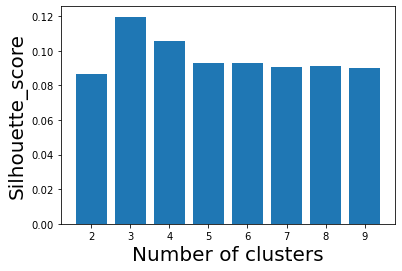

In [130]:
# Calculate 
no_clust=[]
silhouette_scores = [] 
for clust in range (2,10):
    agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                   n_clusters=clust)
    clusters = agg_cluster.fit_predict(dist)
    silhouette_scores.append(metrics.silhouette_score(dist, clusters, metric='precomputed'))
    no_clust.append(clust)  
  
# bar graph to compare silhoute scores for differnt no of cluseters
plt.bar(no_clust, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Silhouette_score', fontsize = 20) 
plt.show() 

Based on the silhoutte score, the optimal number of clusters is three. 

In [131]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                   n_clusters=3)

# Fit model
clusters_hc = agg_cluster.fit(dist)

Assign the cluster labels to a column in our original dataframe.

In [132]:
diab_orig['cluster']=clusters_hc.labels_

In [133]:
diab_orig['cluster'].value_counts()

2    2687
0    1204
1    1109
Name: cluster, dtype: int64

### Explore and interpret clusters

*** Note that cluster interpretation  may differ (reshuffled) as random samples are taken each time the code is run.

In [134]:
# Group mean values of records features(mean for numeric & perentage for categorical) 
# by cluster
diab_with_label=pd.get_dummies(diab_orig).groupby(by="cluster").mean()
diab_with_label.style.background_gradient()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),diag_1_112,diag_1_135,diag_1_151,diag_1_152,diag_1_153,diag_1_154,diag_1_155,diag_1_157,diag_1_158,diag_1_162,diag_1_171,diag_1_174,diag_1_182,diag_1_183,diag_1_185,diag_1_188,diag_1_189,diag_1_191,diag_1_193,diag_1_197,diag_1_198,diag_1_200,diag_1_202,diag_1_203,diag_1_205,diag_1_211,diag_1_218,diag_1_225,diag_1_227,diag_1_233,diag_1_235,diag_1_238,diag_1_241,diag_1_242,diag_1_250,diag_1_250.01,diag_1_250.02,diag_1_250.03,diag_1_250.1,diag_1_250.11,diag_1_250.12,diag_1_250.13,diag_1_250.2,diag_1_250.22,diag_1_250.23,diag_1_250.3,diag_1_250.31,diag_1_250.32,diag_1_250.33,diag_1_250.4,diag_1_250.41,diag_1_250.42,diag_1_250.43,diag_1_250.6,diag_1_250.7,diag_1_250.8,diag_1_250.81,diag_1_250.82,diag_1_250.83,diag_1_250.92,diag_1_250.93,diag_1_251,diag_1_252,diag_1_253,diag_1_255,diag_1_274,diag_1_275,diag_1_276,diag_1_277,diag_1_278,diag_1_280,diag_1_281,diag_1_282,diag_1_283,diag_1_284,diag_1_285,diag_1_286,diag_1_287,diag_1_288,diag_1_290,diag_1_291,diag_1_292,diag_1_293,diag_1_294,diag_1_295,diag_1_296,diag_1_297,diag_1_300,diag_1_303,diag_1_304,diag_1_305,diag_1_311,diag_1_312,diag_1_327,diag_1_331,diag_1_332,diag_1_333,diag_1_345,diag_1_346,diag_1_348,diag_1_351,diag_1_355,diag_1_368,diag_1_38,diag_1_386,diag_1_396,diag_1_398,diag_1_401,diag_1_402,diag_1_403,diag_1_404,diag_1_410,diag_1_411,diag_1_413,diag_1_414,diag_1_415,diag_1_416,diag_1_42,diag_1_420,diag_1_423,diag_1_424,diag_1_425,diag_1_426,diag_1_427,diag_1_428,diag_1_429,diag_1_430,diag_1_431,diag_1_432,diag_1_433,diag_1_434,diag_1_435,diag_1_436,diag_1_437,diag_1_438,diag_1_440,diag_1_441,diag_1_442,diag_1_443,diag_1_444,diag_1_446,diag_1_447,diag_1_451,diag_1_453,diag_1_455,diag_1_458,diag_1_459,diag_1_461,diag_1_465,diag_1_466,diag_1_47,diag_1_473,diag_1_478,diag_1_480,diag_1_481,diag_1_482,diag_1_485,diag_1_486,diag_1_487,diag_1_490,diag_1_491,diag_1_492,diag_1_493,diag_1_494,diag_1_496,diag_1_507,diag_1_511,diag_1_512,diag_1_513,diag_1_515,diag_1_516,diag_1_518,diag_1_522,diag_1_527,diag_1_53,diag_1_530,diag_1_531,diag_1_532,diag_1_533,diag_1_534,diag_1_535,diag_1_536,diag_1_537,diag_1_540,diag_1_550,diag_1_552,diag_1_553,diag_1_555,diag_1_556,diag_1_557,diag_1_558,diag_1_560,diag_1_562,diag_1_564,diag_1_565,diag_1_566,diag_1_567,diag_1_568,diag_1_569,diag_1_571,diag_1_572,diag_1_573,diag_1_574,diag_1_575,diag_1_576,diag_1_577,diag_1_578,diag_1_581,diag_1_584,diag_1_585,diag_1_586,diag_1_590,diag_1_592,diag_1_593,diag_1_595,diag_1_596,diag_1_599,diag_1_600,diag_1_604,diag_1_607,diag_1_608,diag_1_611,diag_1_616,diag_1_617,diag_1_618,diag_1_620,diag_1_621,diag_1_625,diag_1_626,diag_1_642,diag_1_648,diag_1_652,diag_1_654,diag_1_659,diag_1_661,diag_1_681,diag_1_682,diag_1_693,diag_1_695,diag_1_70,diag_1_707,diag_1_711,diag_1_714,diag_1_715,diag_1_716,diag_1_718,diag_1_719,diag_1_721,diag_1_722,diag_1_723,diag_1_724,diag_1_726,diag_1_727,diag_1_728,diag_1_729,diag_1_730,diag_1_733,diag_1_736,diag_1_756,diag_1_780,diag_1_781,diag_1_782,diag_1_783,diag_1_784,diag_1_785,diag_1_786,diag_1_787,diag_1_788,diag_1_789,diag_1_79,diag_1_790,diag_1_794,diag_1_799,diag_1_8,diag_1_802,diag_1_805,diag_1_807,diag_1_808,diag_1_812,diag_1_813,diag_1_820,diag_1_821,diag_1_822,diag_1_823,diag_1_824,diag_1_850,diag_1_851,diag_1_852,diag_1_853,diag_1_860,diag_1_861,diag_1_9,diag_1_922,diag_1_924,diag_1_935,diag_1_959,diag_1_962,diag_1_965,diag_1_967,diag_1_969,diag_1_972,diag_1_995,diag_1_996,diag_1_997,diag_1_998,diag_1_999,diag_1_V53,diag_1_V54,diag_1_V55,diag_1_V57,diag_1_V58,diag_2_112,diag_2_135,diag_2_138,diag_2_150,diag_2_151,diag_2_153,diag_2_154,diag_2_155,diag_2_157,diag_2_162,diag_2_174,diag_2_183,diag_2_185,diag_2_189,diag_2_19

Demographic features grouped by clusters/labels.

In [43]:
demo_feat=diab_with_label.columns[diab_with_label.columns.str.contains('age') | 
                           diab_with_label.columns.str.contains('race')|
                           diab_with_label.columns.str.contains('gender')].tolist()

#Extract demographic summary by clusters/labels
demo_summary=diab_with_label[demo_feat]
demo_summary.style.background_gradient()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
cluster,,,,,,,,,,,,,,,,,
0,0.197674,0.006645,0.750831,0.022425,0.022425,0.665282,0.334718,0.000000,0.004983,0.014120,0.044850,0.125415,0.171927,0.218439,0.230897,0.166944,0.022425
1,0.207394,0.009919,0.752029,0.014427,0.016231,0.380523,0.619477,0.000902,0.002705,0.012624,0.043282,0.072137,0.182146,0.247971,0.276826,0.139766,0.021641
2,0.190175,0.007443,0.775958,0.016747,0.009676,0.557499,0.442501,0.000744,0.002233,0.012281,0.034611,0.088947,0.166357,0.202828,0.263863,0.194641,0.033495


* Cluster 0 
    - Caucasian, Hispanic and others
    - Male
    - 10 to 40 years old
* Cluster 1
    - 40 to 60 years, 70 to 90 years old
* Cluster 2
    - Female
    - 0 to 10 , 60 to 70 years old


In [47]:
diab_with_label_n=diab_orig.groupby(by="cluster").mean()
diab_with_label_n.style.background_gradient()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
cluster,,,,,,,,
0,4.763289,44.642027,1.361296,18.436877,0.367110,0.258306,0.749169,7.687708
1,4.565374,44.065825,1.318305,17.733995,0.444545,0.201082,0.660956,7.422002
2,4.047637,41.647934,1.400819,14.254559,0.319315,0.167845,0.637142,7.475251


- Cluster 1
    - longer stay in hospital, having higher number of procedures, have frequent visit history as outpatient and inpatient
    and having higher number of diagnosis

Diagnosis information grouped by clusters

In [49]:
diag_1= diab_with_label.filter(regex="diag_1")
diag_1.style.background_gradient()

,diag_1_112,diag_1_135,diag_1_151,diag_1_152,diag_1_153,diag_1_154,diag_1_155,diag_1_157,diag_1_158,diag_1_162,diag_1_171,diag_1_174,diag_1_182,diag_1_183,diag_1_185,diag_1_188,diag_1_189,diag_1_191,diag_1_193,diag_1_197,diag_1_198,diag_1_200,diag_1_202,diag_1_203,diag_1_205,diag_1_211,diag_1_218,diag_1_225,diag_1_227,diag_1_233,diag_1_235,diag_1_238,diag_1_241,diag_1_242,diag_1_250,diag_1_250.01,diag_1_250.02,diag_1_250.03,diag_1_250.1,diag_1_250.11,diag_1_250.12,diag_1_250.13,diag_1_250.2,diag_1_250.22,diag_1_250.23,diag_1_250.3,diag_1_250.31,diag_1_250.32,diag_1_250.33,diag_1_250.4,diag_1_250.41,diag_1_250.42,diag_1_250.43,diag_1_250.6,diag_1_250.7,diag_1_250.8,diag_1_250.81,diag_1_250.82,diag_1_250.83,diag_1_250.92,diag_1_250.93,diag_1_251,diag_1_252,diag_1_253,diag_1_255,diag_1_274,diag_1_275,diag_1_276,diag_1_277,diag_1_278,diag_1_280,diag_1_281,diag_1_282,diag_1_283,diag_1_284,diag_1_285,diag_1_286,diag_1_287,diag_1_288,diag_1_290,diag_1_291,diag_1_292,diag_1_293,diag_1_294,diag_1_295,diag_1_296,diag_1_297,diag_1_300,diag_1_303,diag_1_304,diag_1_305,diag_1_311,diag_1_312,diag_1_327,diag_1_331,diag_1_332,diag_1_333,diag_1_345,diag_1_346,diag_1_348,diag_1_351,diag_1_355,diag_1_368,diag_1_38,diag_1_386,diag_1_396,diag_1_398,diag_1_401,diag_1_402,diag_1_403,diag_1_404,diag_1_410,diag_1_411,diag_1_413,diag_1_414,diag_1_415,diag_1_416,diag_1_42,diag_1_420,diag_1_423,diag_1_424,diag_1_425,diag_1_426,diag_1_427,diag_1_428,diag_1_429,diag_1_430,diag_1_431,diag_1_432,diag_1_433,diag_1_434,diag_1_435,diag_1_436,diag_1_437,diag_1_438,diag_1_440,diag_1_441,diag_1_442,diag_1_443,diag_1_444,diag_1_446,diag_1_447,diag_1_451,diag_1_453,diag_1_455,diag_1_458,diag_1_459,diag_1_461,diag_1_465,diag_1_466,diag_1_47,diag_1_473,diag_1_478,diag_1_480,diag_1_481,diag_1_482,diag_1_485,diag_1_486,diag_1_487,diag_1_490,diag_1_491,diag_1_492,diag_1_493,diag_1_494,diag_1_496,diag_1_507,diag_1_511,diag_1_512,diag_1_513,diag_1_515,diag_1_516,diag_1_518,diag_1_522,diag_1_527,diag_1_53,diag_1_530,diag_1_531,diag_1_532,diag_1_533,diag_1_534,diag_1_535,diag_1_536,diag_1_537,diag_1_540,diag_1_550,diag_1_552,diag_1_553,diag_1_555,diag_1_556,diag_1_557,diag_1_558,diag_1_560,diag_1_562,diag_1_564,diag_1_565,diag_1_566,diag_1_567,diag_1_568,diag_1_569,diag_1_571,diag_1_572,diag_1_573,diag_1_574,diag_1_575,diag_1_576,diag_1_577,diag_1_578,diag_1_581,diag_1_584,diag_1_585,diag_1_586,diag_1_590,diag_1_592,diag_1_593,diag_1_595,diag_1_596,diag_1_599,diag_1_600,diag_1_604,diag_1_607,diag_1_608,diag_1_611,diag_1_616,diag_1_617,diag_1_618,diag_1_620,diag_1_621,diag_1_625,diag_1_626,diag_1_642,diag_1_648,diag_1_652,diag_1_654,diag_1_659,diag_1_661,diag_1_681,diag_1_682,diag_1_693,diag_1_695,diag_1_70,diag_1_707,diag_1_711,diag_1_714,diag_1_715,diag_1_716,diag_1_718,diag_1_719,diag_1_721,diag_1_722,diag_1_723,diag_1_724,diag_1_726,diag_1_727,diag_1_728,diag_1_729,diag_1_730,diag_1_733,diag_1_736,diag_1_756,diag_1_780,diag_1_781,diag_1_782,diag_1_783,diag_1_784,diag_1_785,diag_1_786,diag_1_787,diag_1_788,diag_1_789,diag_1_79,diag_1_790,diag_1_794,diag_1_799,diag_1_8,diag_1_802,diag_1_805,diag_1_807,diag_1_808,diag_1_812,diag_1_813,diag_1_820,diag_1_821,diag_1_822,diag_1_823,diag_1_824,diag_1_850,diag_1_851,diag_1_852,diag_1_853,diag_1_860,diag_1_861,diag_1_9,diag_1_922,diag_1_924,diag_1_935,diag_1_959,diag_1_962,diag_1_965,diag_1_967,diag_1_969,diag_1_972,diag_1_995,diag_1_996,diag_1_997,diag_1_998,diag_1_999,diag_1_V53,diag_1_V54,diag_1_V55,diag_1_V57,diag_1_V58
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000831,0.002492,0.000831,0.000831,0.000000,0.000000,0.003322,0.000000,0.001661,0.001661,0.000000,0.000000,0.001661,0.000000,0.001661,0.000000,0.001661,0.003322,0.00000

In [139]:
med_up= diab_with_label.filter(regex="_Up")
med_up.style.background_gradient()

,metformin_Up,repaglinide_Up,nateglinide_Up,glipizide_Up,glyburide_Up,pioglitazone_Up,rosiglitazone_Up,insulin_Up
cluster,,,,,,,,
0,0.028239,0.000000,0.001661,0.014950,0.012458,0.005814,0.007475,0.310631
1,0.017133,0.003607,0.000000,0.022543,0.018034,0.008115,0.004509,0.144274
2,0.000000,0.000000,0.000000,0.000000,0.000372,0.000372,0.000000,0.000744


In [50]:
diag_2= diab_with_label.filter(regex="diag_2")
diag_2.style.background_gradient()

,diag_2_112,diag_2_135,diag_2_138,diag_2_150,diag_2_151,diag_2_153,diag_2_154,diag_2_155,diag_2_157,diag_2_162,diag_2_174,diag_2_183,diag_2_185,diag_2_189,diag_2_191,diag_2_196,diag_2_197,diag_2_198,diag_2_199,diag_2_200,diag_2_201,diag_2_202,diag_2_203,diag_2_204,diag_2_205,diag_2_211,diag_2_218,diag_2_233,diag_2_238,diag_2_242,diag_2_244,diag_2_250,diag_2_250.01,diag_2_250.02,diag_2_250.03,diag_2_250.1,diag_2_250.11,diag_2_250.12,diag_2_250.13,diag_2_250.4,diag_2_250.41,diag_2_250.42,diag_2_250.43,diag_2_250.5,diag_2_250.51,diag_2_250.52,diag_2_250.53,diag_2_250.6,diag_2_250.7,diag_2_250.8,diag_2_250.81,diag_2_250.82,diag_2_250.92,diag_2_252,diag_2_262,diag_2_263,diag_2_272,diag_2_275,diag_2_276,diag_2_277,diag_2_278,diag_2_280,diag_2_281,diag_2_282,diag_2_283,diag_2_284,diag_2_285,diag_2_286,diag_2_287,diag_2_288,diag_2_290,diag_2_291,diag_2_292,diag_2_293,diag_2_294,diag_2_295,diag_2_296,diag_2_298,diag_2_300,diag_2_301,diag_2_303,diag_2_304,diag_2_305,diag_2_309,diag_2_311,diag_2_312,diag_2_327,diag_2_331,diag_2_332,diag_2_333,diag_2_337,diag_2_338,diag_2_340,diag_2_342,diag_2_344,diag_2_345,diag_2_346,diag_2_348,diag_2_349,diag_2_357,diag_2_358,diag_2_362,diag_2_368,diag_2_38,diag_2_396,diag_2_397,diag_2_40,diag_2_401,diag_2_402,diag_2_403,diag_2_404,diag_2_41,diag_2_410,diag_2_411,diag_2_412,diag_2_413,diag_2_414,diag_2_415,diag_2_416,diag_2_42,diag_2_420,diag_2_421,diag_2_423,diag_2_424,diag_2_425,diag_2_426,diag_2_427,diag_2_428,diag_2_429,diag_2_431,diag_2_433,diag_2_434,diag_2_435,diag_2_437,diag_2_438,diag_2_440,diag_2_441,diag_2_442,diag_2_443,diag_2_444,diag_2_447,diag_2_451,diag_2_453,diag_2_455,diag_2_456,diag_2_458,diag_2_459,diag_2_462,diag_2_465,diag_2_466,diag_2_473,diag_2_481,diag_2_482,diag_2_486,diag_2_487,diag_2_490,diag_2_491,diag_2_492,diag_2_493,diag_2_496,diag_2_507,diag_2_511,diag_2_512,diag_2_515,diag_2_516,diag_2_518,diag_2_519,diag_2_53,diag_2_530,diag_2_532,diag_2_535,diag_2_536,diag_2_537,diag_2_550,diag_2_552,diag_2_553,diag_2_555,diag_2_556,diag_2_557,diag_2_558,diag_2_560,diag_2_562,diag_2_564,diag_2_566,diag_2_567,diag_2_568,diag_2_569,diag_2_570,diag_2_571,diag_2_572,diag_2_573,diag_2_574,diag_2_575,diag_2_576,diag_2_577,diag_2_578,diag_2_581,diag_2_583,diag_2_584,diag_2_585,diag_2_590,diag_2_591,diag_2_592,diag_2_593,diag_2_595,diag_2_596,diag_2_599,diag_2_611,diag_2_614,diag_2_616,diag_2_618,diag_2_620,diag_2_625,diag_2_626,diag_2_627,diag_2_642,diag_2_648,diag_2_680,diag_2_681,diag_2_682,diag_2_693,diag_2_70,diag_2_707,diag_2_710,diag_2_711,diag_2_714,diag_2_715,diag_2_718,diag_2_719,diag_2_721,diag_2_722,diag_2_723,diag_2_724,diag_2_727,diag_2_728,diag_2_729,diag_2_730,diag_2_731,diag_2_733,diag_2_736,diag_2_738,diag_2_746,diag_2_753,diag_2_756,diag_2_780,diag_2_781,diag_2_782,diag_2_784,diag_2_785,diag_2_786,diag_2_787,diag_2_788,diag_2_789,diag_2_790,diag_2_794,diag_2_799,diag_2_8,diag_2_802,diag_2_805,diag_2_807,diag_2_808,diag_2_812,diag_2_813,diag_2_820,diag_2_821,diag_2_852,diag_2_920,diag_2_924,diag_2_94,diag_2_959,diag_2_995,diag_2_996,diag_2_997,diag_2_998,diag_2_999,diag_2_E849,diag_2_E878,diag_2_E879,diag_2_E880,diag_2_E884,diag_2_E885,diag_2_E888,diag_2_E928,diag_2_E935,diag_2_E939,diag_2_E944,diag_2_E947,diag_2_V10,diag_2_V12,diag_2_V15,diag_2_V42,diag_2_V43,diag_2_V45,diag_2_V49,diag_2_V54,diag_2_V58,diag_2_V62,diag_2_V63,diag_2_V64,diag_2_V65,diag_2_V85
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.003322,0.004153,0.000000,0.000000,0.000000,0.000831,0.000831,0.000000,0.000831,0.001661,0.000831,0.000000,0.000000,0.000000,0.000000,0.001661,0.003322,0.004153,0.000000,0.000000,0.000000,0.002492,0.001661,0.000000,0.000831,0.000831,0.000000,0.000831,0.000000,0.000831,0.001661,0.056478,0.012458,0.022425,0.001661,0.

In [51]:
diag_3= diab_with_label.filter(regex="diag_3")
diag_3.style.background_gradient()

,diag_3_110,diag_3_112,diag_3_135,diag_3_138,diag_3_153,diag_3_157,diag_3_162,diag_3_174,diag_3_185,diag_3_188,diag_3_189,diag_3_196,diag_3_197,diag_3_198,diag_3_199,diag_3_201,diag_3_202,diag_3_203,diag_3_204,diag_3_205,diag_3_211,diag_3_218,diag_3_238,diag_3_242,diag_3_244,diag_3_250,diag_3_250.01,diag_3_250.02,diag_3_250.03,diag_3_250.1,diag_3_250.12,diag_3_250.4,diag_3_250.41,diag_3_250.42,diag_3_250.43,diag_3_250.5,diag_3_250.51,diag_3_250.52,diag_3_250.53,diag_3_250.6,diag_3_250.7,diag_3_250.8,diag_3_250.81,diag_3_250.82,diag_3_250.83,diag_3_250.92,diag_3_250.93,diag_3_252,diag_3_253,diag_3_255,diag_3_263,diag_3_266,diag_3_272,diag_3_273,diag_3_275,diag_3_276,diag_3_277,diag_3_278,diag_3_280,diag_3_282,diag_3_284,diag_3_285,diag_3_286,diag_3_287,diag_3_288,diag_3_289,diag_3_290,diag_3_291,diag_3_292,diag_3_293,diag_3_294,diag_3_295,diag_3_296,diag_3_300,diag_3_301,diag_3_303,diag_3_304,diag_3_305,diag_3_309,diag_3_310,diag_3_311,diag_3_312,diag_3_319,diag_3_327,diag_3_331,diag_3_332,diag_3_333,diag_3_337,diag_3_338,diag_3_340,diag_3_342,diag_3_343,diag_3_344,diag_3_345,diag_3_348,diag_3_356,diag_3_357,diag_3_358,diag_3_362,diag_3_365,diag_3_368,diag_3_369,diag_3_38,diag_3_389,diag_3_396,diag_3_397,diag_3_398,diag_3_401,diag_3_402,diag_3_403,diag_3_404,diag_3_41,diag_3_410,diag_3_411,diag_3_412,diag_3_413,diag_3_414,diag_3_416,diag_3_42,diag_3_423,diag_3_424,diag_3_425,diag_3_426,diag_3_427,diag_3_428,diag_3_429,diag_3_433,diag_3_434,diag_3_435,diag_3_437,diag_3_438,diag_3_440,diag_3_441,diag_3_442,diag_3_443,diag_3_444,diag_3_447,diag_3_453,diag_3_454,diag_3_455,diag_3_458,diag_3_459,diag_3_465,diag_3_466,diag_3_473,diag_3_478,diag_3_482,diag_3_486,diag_3_490,diag_3_491,diag_3_492,diag_3_493,diag_3_496,diag_3_507,diag_3_511,diag_3_514,diag_3_515,diag_3_517,diag_3_518,diag_3_519,diag_3_522,diag_3_53,diag_3_530,diag_3_531,diag_3_532,diag_3_533,diag_3_535,diag_3_536,diag_3_537,diag_3_552,diag_3_553,diag_3_555,diag_3_556,diag_3_558,diag_3_560,diag_3_562,diag_3_564,diag_3_568,diag_3_569,diag_3_570,diag_3_571,diag_3_572,diag_3_573,diag_3_574,diag_3_575,diag_3_576,diag_3_577,diag_3_578,diag_3_581,diag_3_582,diag_3_583,diag_3_584,diag_3_585,diag_3_586,diag_3_590,diag_3_591,diag_3_592,diag_3_593,diag_3_595,diag_3_596,diag_3_598,diag_3_599,diag_3_600,diag_3_601,diag_3_608,diag_3_614,diag_3_616,diag_3_617,diag_3_618,diag_3_620,diag_3_625,diag_3_626,diag_3_642,diag_3_648,diag_3_659,diag_3_664,diag_3_681,diag_3_682,diag_3_693,diag_3_696,diag_3_70,diag_3_707,diag_3_709,diag_3_710,diag_3_711,diag_3_713,diag_3_714,diag_3_715,diag_3_716,diag_3_719,diag_3_721,diag_3_722,diag_3_723,diag_3_724,diag_3_728,diag_3_729,diag_3_730,diag_3_731,diag_3_733,diag_3_736,diag_3_737,diag_3_738,diag_3_753,diag_3_780,diag_3_781,diag_3_782,diag_3_783,diag_3_784,diag_3_785,diag_3_786,diag_3_787,diag_3_788,diag_3_789,diag_3_79,diag_3_790,diag_3_792,diag_3_794,diag_3_796,diag_3_799,diag_3_8,diag_3_802,diag_3_805,diag_3_807,diag_3_808,diag_3_813,diag_3_820,diag_3_824,diag_3_873,diag_3_905,diag_3_923,diag_3_924,diag_3_995,diag_3_996,diag_3_997,diag_3_998,diag_3_999,diag_3_E849,diag_3_E878,diag_3_E879,diag_3_E885,diag_3_E888,diag_3_E931,diag_3_E932,diag_3_E933,diag_3_E934,diag_3_E935,diag_3_E939,diag_3_E942,diag_3_E944,diag_3_E947,diag_3_V09,diag_3_V10,diag_3_V12,diag_3_V14,diag_3_V15,diag_3_V17,diag_3_V42,diag_3_V43,diag_3_V45,diag_3_V46,diag_3_V49,diag_3_V54,diag_3_V58,diag_3_V62,diag_3_V63,diag_3_V64,diag_3_V85
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.003322,0.000000,0.000831,0.000000,0.000000,0.002492,0.001661,0.000000,0.000000,0.000831,0.000831,0.004153,0.002492,0.000000,0.000000,0.000831,0.000831,0.000831,0.000000,0.000831,0.000000,0.000831,0.000831,0.008306,0.094684,0.004983

Extract and compare clusters based on investigation result

In [52]:
diab_lab=diab_with_label.columns[diab_with_label.columns.str.contains('serum') | 
                           diab_with_label.columns.str.contains('A1C')|
                           diab_with_label.columns.str.contains('readmitted')|
                           diab_with_label.columns.str.contains('insulin')].tolist()

lab_summary=diab_with_label[diab_lab]
lab_summary.style.background_gradient()

,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,readmitted_<30,readmitted_>30,readmitted_NO
cluster,,,,,,,,,,,,,,,
0,0.019934,0.027409,0.936047,0.016611,0.044020,0.127907,0.780731,0.047342,0.265781,0.127076,0.296512,0.310631,0.164452,0.263289,0.572259
1,0.014427,0.017133,0.954013,0.014427,0.042381,0.111812,0.800721,0.045086,0.238954,0.267809,0.348963,0.144274,0.085663,0.510370,0.403968
2,0.016003,0.010421,0.949014,0.024563,0.027540,0.042426,0.883141,0.046892,0.000372,0.702270,0.296613,0.000744,0.110904,0.330108,0.558988


Cluster 0:
    - Patients with higher blood glucose level and higher 3 months average blood blood glucose who increased insulin dosage
    
Cluster 1:
    - Patients wih relateively within normal blood sugar range who lowered insulin
    
Cluster 2:
    - Patients with normal range of blood sugar but required to increase insulin intake, readmited with in 30 days of hospitalization


Cluster by age summary and plot:

race,AfricanAmerican,Asian,Caucasian,Hispanic,Other
cluster,,,,,
0,238,8,904,27,27
1,230,11,834,16,18
2,511,20,2085,45,26


C:\DS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


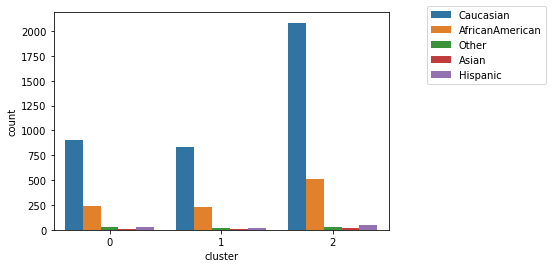

In [135]:
age_label_ct = pd.crosstab(diab_orig["cluster"], diab_orig["race"])
display(age_label_ct.style.background_gradient(axis=1))

sns.countplot("cluster",hue="race", data=diab_orig)
plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Evaluation

In [152]:
y=diab_orig['readmitted']
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='precomputed',
                                   n_clusters=3)

# Fit model
y_pred = agg_cluster.fit_predict(dist)

pd.crosstab(y, y_pred) 

col_0,0,1,2
readmitted,,,
<30,198,95,298
>30,317,566,887
NO,689,448,1502


In [54]:
clusters_hc_pred=agg_cluster.fit_predict(dist)
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(dist, clusters_hc_pred, metric='precomputed')))

The silhoutte score of the Agglomerative Clustering solution: 0.11971252411603928


Assumption:

Population -patient dataset, n= 98053 

Sample size: n=5000

Calculated and recorded Silhouette score 10 times:

    - Scores: 0.14,0.25,0.16,0.23,0.41,0.21,0.18,0.37,0.26,0.12
    - Calculated the mean: 0.29
    
Based on Central Limit Theorem, we can assume that the sampling distribution of the mean will be normal; the mean of a sample of data will be closer to the mean of the overall population. Due to computational complexity, though a small number of samples(scores- 10), we can assume the mean Silhouette score gets closer to the mean of the entire dataset, which is 0.29.

## Cluster with K-medoids

We need to initialize the starting 'medoids' for our clusters. To do this, we needto provide the indices of our starting points.

In [101]:
k = 3

In [102]:
# Generate k random indices from our distance matrix
np.random.seed(42)

nrows = dist.shape[0]
init_medoids = np.random.randint(0, nrows, k)
init_medoids

array([ 860, 3772, 3092])

In [103]:
kmed = kmedoids(
    dist, initial_index_medoids=init_medoids, data_type="distance_matrix"
)

kmed.process()

In [104]:
# Use the .get_medoids() method to find the index for each cluster center.
medoid_idxs = kmed.get_medoids()
medoid_idxs

[2748, 4340, 1176]

In [63]:
# Use the .predict() method to output the cluster label for each record in a dataset
labels = kmed.predict(dist)
labels

array([0, 1, 0, ..., 2, 0, 1], dtype=int64)

In [105]:
# Save a copy of the datasets
diab_orig_k=diab_orig.copy()
diabitic_K=diabetic.copy()

In [106]:
# Put the labels into both the original and scaled/encoded dataframes

diab_orig_k["label"] = labels
diabitic_K["label"] = labels

## Explore Clusters


In [109]:
# Use the medoid_idxs to pull out our cluster centers from the original dataset

diab_orig_k.iloc[medoid_idxs, :]

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted,label
93585,Caucasian,Female,[60-70),2,42,0,10,0,0,0,...,No,No,No,No,No,No,No,No,NO,1
63780,Caucasian,Female,[70-80),3,48,0,9,0,0,0,...,No,No,No,No,Steady,No,No,Yes,NO,2
57323,Caucasian,Male,[60-70),5,44,1,20,0,1,1,...,No,No,No,No,Down,No,Ch,Yes,>30,0


In [123]:
# Group mean values of records features(mean for numeric & perentage for categorical) 
# by cluster
diab_with_label_k=pd.get_dummies(diab_orig_k).groupby(by="label").mean()
diab_with_label_k.style.background_gradient()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),diag_1_112,diag_1_135,diag_1_151,diag_1_152,diag_1_153,diag_1_154,diag_1_155,diag_1_157,diag_1_158,diag_1_162,diag_1_171,diag_1_174,diag_1_182,diag_1_183,diag_1_185,diag_1_188,diag_1_189,diag_1_191,diag_1_193,diag_1_197,diag_1_198,diag_1_200,diag_1_202,diag_1_203,diag_1_205,diag_1_211,diag_1_218,diag_1_225,diag_1_227,diag_1_233,diag_1_235,diag_1_238,diag_1_241,diag_1_242,diag_1_250,diag_1_250.01,diag_1_250.02,diag_1_250.03,diag_1_250.1,diag_1_250.11,diag_1_250.12,diag_1_250.13,diag_1_250.2,diag_1_250.22,diag_1_250.23,diag_1_250.3,diag_1_250.31,diag_1_250.32,diag_1_250.33,diag_1_250.4,diag_1_250.41,diag_1_250.42,diag_1_250.43,diag_1_250.6,diag_1_250.7,diag_1_250.8,diag_1_250.81,diag_1_250.82,diag_1_250.83,diag_1_250.92,diag_1_250.93,diag_1_251,diag_1_252,diag_1_253,diag_1_255,diag_1_274,diag_1_275,diag_1_276,diag_1_277,diag_1_278,diag_1_280,diag_1_281,diag_1_282,diag_1_283,diag_1_284,diag_1_285,diag_1_286,diag_1_287,diag_1_288,diag_1_290,diag_1_291,diag_1_292,diag_1_293,diag_1_294,diag_1_295,diag_1_296,diag_1_297,diag_1_300,diag_1_303,diag_1_304,diag_1_305,diag_1_311,diag_1_312,diag_1_327,diag_1_331,diag_1_332,diag_1_333,diag_1_345,diag_1_346,diag_1_348,diag_1_351,diag_1_355,diag_1_368,diag_1_38,diag_1_386,diag_1_396,diag_1_398,diag_1_401,diag_1_402,diag_1_403,diag_1_404,diag_1_410,diag_1_411,diag_1_413,diag_1_414,diag_1_415,diag_1_416,diag_1_42,diag_1_420,diag_1_423,diag_1_424,diag_1_425,diag_1_426,diag_1_427,diag_1_428,diag_1_429,diag_1_430,diag_1_431,diag_1_432,diag_1_433,diag_1_434,diag_1_435,diag_1_436,diag_1_437,diag_1_438,diag_1_440,diag_1_441,diag_1_442,diag_1_443,diag_1_444,diag_1_446,diag_1_447,diag_1_451,diag_1_453,diag_1_455,diag_1_458,diag_1_459,diag_1_461,diag_1_465,diag_1_466,diag_1_47,diag_1_473,diag_1_478,diag_1_480,diag_1_481,diag_1_482,diag_1_485,diag_1_486,diag_1_487,diag_1_490,diag_1_491,diag_1_492,diag_1_493,diag_1_494,diag_1_496,diag_1_507,diag_1_511,diag_1_512,diag_1_513,diag_1_515,diag_1_516,diag_1_518,diag_1_522,diag_1_527,diag_1_53,diag_1_530,diag_1_531,diag_1_532,diag_1_533,diag_1_534,diag_1_535,diag_1_536,diag_1_537,diag_1_540,diag_1_550,diag_1_552,diag_1_553,diag_1_555,diag_1_556,diag_1_557,diag_1_558,diag_1_560,diag_1_562,diag_1_564,diag_1_565,diag_1_566,diag_1_567,diag_1_568,diag_1_569,diag_1_571,diag_1_572,diag_1_573,diag_1_574,diag_1_575,diag_1_576,diag_1_577,diag_1_578,diag_1_581,diag_1_584,diag_1_585,diag_1_586,diag_1_590,diag_1_592,diag_1_593,diag_1_595,diag_1_596,diag_1_599,diag_1_600,diag_1_604,diag_1_607,diag_1_608,diag_1_611,diag_1_616,diag_1_617,diag_1_618,diag_1_620,diag_1_621,diag_1_625,diag_1_626,diag_1_642,diag_1_648,diag_1_652,diag_1_654,diag_1_659,diag_1_661,diag_1_681,diag_1_682,diag_1_693,diag_1_695,diag_1_70,diag_1_707,diag_1_711,diag_1_714,diag_1_715,diag_1_716,diag_1_718,diag_1_719,diag_1_721,diag_1_722,diag_1_723,diag_1_724,diag_1_726,diag_1_727,diag_1_728,diag_1_729,diag_1_730,diag_1_733,diag_1_736,diag_1_756,diag_1_780,diag_1_781,diag_1_782,diag_1_783,diag_1_784,diag_1_785,diag_1_786,diag_1_787,diag_1_788,diag_1_789,diag_1_79,diag_1_790,diag_1_794,diag_1_799,diag_1_8,diag_1_802,diag_1_805,diag_1_807,diag_1_808,diag_1_812,diag_1_813,diag_1_820,diag_1_821,diag_1_822,diag_1_823,diag_1_824,diag_1_850,diag_1_851,diag_1_852,diag_1_853,diag_1_860,diag_1_861,diag_1_9,diag_1_922,diag_1_924,diag_1_935,diag_1_959,diag_1_962,diag_1_965,diag_1_967,diag_1_969,diag_1_972,diag_1_995,diag_1_996,diag_1_997,diag_1_998,diag_1_999,diag_1_V53,diag_1_V54,diag_1_V55,diag_1_V57,diag_1_V58,diag_2_112,diag_2_135,diag_2_138,diag_2_150,diag_2_151,diag_2_153,diag_2_154,diag_2_155,diag_2_157,diag_2_162,diag_2_174,diag_2_183,diag_2_185,diag_2_189,diag_2_19

In [126]:
demo_feat_k=diab_with_label_k.columns[diab_with_label_k.columns.str.contains('age') | 
                           diab_with_label_k.columns.str.contains('race')|
                           diab_with_label_k.columns.str.contains('gender')].tolist()

#Extract demographic summary by clusters/labels
demo_summary=diab_with_label_k[demo_feat_k]
demo_summary.style.background_gradient()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
label,,,,,,,,,,,,,,,,,
0,0.198011,0.010376,0.755728,0.020752,0.015132,0.544747,0.455253,0.000865,0.003026,0.011241,0.041072,0.095547,0.174233,0.214872,0.251621,0.178988,0.028534
1,0.191304,0.006211,0.774534,0.012422,0.015528,0.536025,0.463975,0.000621,0.003106,0.016770,0.038509,0.090062,0.176398,0.209317,0.257764,0.174534,0.032919
2,0.197772,0.004643,0.768802,0.018570,0.010214,0.555246,0.444754,0.000000,0.002786,0.010214,0.035283,0.096565,0.156917,0.231198,0.275766,0.170845,0.020427


In [113]:
cluster_avgs = diabitic_K.groupby("label").mean()
cluster_avgs


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
label,,,,,,,,,,,,,,,,,,,,,
0,0.014184,0.004231,-0.006966,-0.009671,0.000217,-0.004326,-0.000441,-0.023227,0.198011,0.010376,...,0.113273,0.993083,0.006917,0.444877,0.555123,0.251189,0.748811,0.115435,0.367488,0.517077
1,0.020245,-0.019676,-0.022911,0.001482,-0.009113,0.005541,0.005402,0.024277,0.191304,0.006211,...,0.108696,0.995652,0.004348,0.477019,0.522981,0.227950,0.772050,0.121118,0.348447,0.530435
2,-0.060727,0.020327,0.049210,0.018554,0.013158,0.001008,-0.007128,0.013592,0.197772,0.004643,...,0.091922,0.992572,0.007428,0.449396,0.550604,0.233983,0.766017,0.119777,0.333333,0.546890


In [116]:
# Most defining cluster 0 characteristics
cluster_avgs.T.sort_values(0,ascending=False).head(50)


label,0,1,2
troglitazone_No,1.000000,1.000000,1.000000
tolbutamide_No,1.000000,0.999379,1.000000
miglitol_No,0.999568,1.000000,0.999071
chlorpropamide_No,0.999568,1.000000,1.000000
tolazamide_No,0.998703,0.999379,0.999071
acarbose_No,0.996109,0.997516,0.997214
nateglinide_No,0.993515,0.992547,0.993500
glyburide-metformin_No,0.993083,0.995652,0.992572
repaglinide_No,0.989624,0.981366,0.987001
rosiglitazone_No,0.944228,0.934783,0.920149


In [127]:
# Most defining cluster 1 characteristics
cluster_avgs.T.sort_values(1,ascending=False).head(50)

label,0,1,2
troglitazone_No,1.000000,1.000000,1.000000
chlorpropamide_No,0.999568,1.000000,1.000000
miglitol_No,0.999568,1.000000,0.999071
tolbutamide_No,1.000000,0.999379,1.000000
tolazamide_No,0.998703,0.999379,0.999071
acarbose_No,0.996109,0.997516,0.997214
glyburide-metformin_No,0.993083,0.995652,0.992572
nateglinide_No,0.993515,0.992547,0.993500
repaglinide_No,0.989624,0.981366,0.987001
max_glu_serum_None,0.944228,0.944720,0.956360


In [ ]:
# Most defining cluster 2 characteristics
cluster_avgs.T.sort_values(2,ascending=False).head(50)

## Cluster Evaluation

In [114]:
# labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(dist, labels, metric='precomputed'))

-0.0026341178


Assumption:

Population -patient dataset, n= 98053

Sample size: n=5000

Calculated and recorded Silhouette score 10 times:

- Scores: 0.01,-0.23,0.11,-0.05,0.09,1.32,0.06,0.17,0.08,-0.0.003
- Calculated the mean: 0.16
Based on Central Limit Theorem, we can assume that the sampling distribution of the mean will be normal; the mean of a sample of data will be closer to the mean of the overall population. Due to computational complexity, though a small number of samples(scores- 10), we can assume the mean Silhouette score gets closer to the mean of the entire dataset, which is 0.16.

# Conclusion

Due to computation complexity only a random sample with a size of 5000 drawn from an inpatient dataset of 98035.
All Data Exploratory Analysis steps have been followed.
Two clustering algorithms have been evaluated: Hierarchical clustering and k-medoids.
Based on their silhoutte scores, hierarchical clustering seems to do better in grouping itmes in to their own cluster than other clusters compared with k-medoids. However, these results do not reflect the entire performance of the clustering algorithms due to the limitation of the evaluation method as well as the dataset used.